## ECG Prediction Algorithm and Evaluation

- The algorithm will be patient-specific, and trained with the first 3 seizures of the patient.

In [1]:
import os

import biosppy as bp
import biosppy.quality as quality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

from preepiseizures.src import Patient, Biosignal, Prediction, biosignal_processing

import warnings
warnings.filterwarnings("ignore")

### 1. Get Patient class and metadata

In [2]:
patient = 'SYRH'
patient_info = Patient.patient_class(patient)
patient_info.get_seizure_annotations()
patient_info.seizure_table

,Crises,Data,Hora Clínica,Localização,lado,Focal / Generalisada,EDA %,PPG %,Duração (s),Sono/ Vigília,Tipo,Count,Timestamp
0,Crise 1,2021-04-14,19:59:44,T,L,FIAS,NaN,NaN,57,Vigília,NaN,1,2021-04-14 19:59:44
1,Crise 2,2021-04-15,02:38:37,T,R,FAS,NaN,NaN,203,Vigília,NaN,2,2021-04-15 02:38:37
2,Crise 3,2021-04-15,09:34:24,T,R,FAS,NaN,NaN,92,Vigília,NaN,3,2021-04-15 09:34:24
3,Crise 4,2021-04-15,12:16:14,T,R,FAS,NaN,NaN,19,Vigília,NaN,4,2021-04-15 12:16:14
4,Crise 5,2021-04-15,14:47:32,T,R,FAS,NaN,NaN,91,Vigília,NaN,5,2021-04-15 14:47:32
5,Crise 6,2021-04-15,18:25:49,T,R,FAS,NaN,NaN,20,Vigília,NaN,6,2021-04-15 18:25:49
6,Crise 7,2021-04-16,13:11:26,T,BL,FIAS,NaN,NaN,83,Vigília,NaN,7,2021-04-16 13:11:26
7,Crise 8,2021-04-16,15:08:26,T,BL,FIAS,NaN,NaN,203,Vigília,NaN,8,2021-04-16 15:08:26


In [ ]:
# get ECG data

sensor = 'ecg'
source = 'hospital'
device = 'chestbit'
biosignal = Biosignal.Biosignal(sensor, device, source)
check = biosignal.get_ecg_hospital_data(patient_class=patient_info)
if check == 1:
    print('ECG data loaded.')
else:
    print('ECG data not loaded.')


In [ ]:
# get data around seizure
# onset = patient_info.seizure_table['Timestamp'].iloc[1]
all_data = pd.concat([pd.read_parquet(os.path.join('data', 'segments', patient, filename)) for filename in sorted(os.listdir(f'data{os.sep}segments{os.sep}{patient}'))])
all_data['datetime'] = all_data.index
all_data.set_index('datetime', inplace=True)
all_data.head(5)

In [ ]:
all_data['10S'] = all_data.index
all_data['10S'] = all_data['10S'].dt.round('10S')

# Extract R peaks for all data

In [ ]:
all_data['1H'] = all_data.index
all_data['1H'] = all_data['1H'].dt.round('1H')
rpeaks = all_data.groupby(by='1H').apply(lambda x: biosignal_processing.get_rpeaks(x))

In [ ]:
all_data['rpeaks'] = 0

In [ ]:
all_data.loc[all_data['1H'] == rpeaks.index[0]].iloc[rpeaks.iloc[0]]['rpeaks'] = 1

In [ ]:
for i in range(len(rpeaks)):
    all_data.loc[all_data.loc[all_data['1H'] == rpeaks.index[i]].iloc[rpeaks.iloc[i]].index, 'rpeaks'] = 1

# Extract quality level for all data

In [ ]:
quality_points = all_data.groupby(by='10S').apply(lambda x: biosignal_processing.get_ecg_quality(x))

In [ ]:
data_final = all_data.merge(quality_points.rename('quality'), left_on='10S', right_index=True)

# Define dataset

In [5]:
data_final = pd.read_pickle(os.path.join('data', patient + '_hrv_data.pkl'))
data_final.index.name = 'datetime'

In [9]:
data_final.index.name = 'datetime'

In [10]:
dataset = Prediction.DatasetPred(data=data_final)
predictor = Prediction.PredictionEval()
dataset_data = dataset.load_data(patient_info=patient_info, data=data_final)

Data loaded successfully


In [12]:
annotated_dataset = dataset.annotate_data(data= dataset_data)

In [13]:
annotated_dataset

,hr_min,hr_max,hr_minmax,rr_min,rr_max,rr_minmax,rr_mean,rr_median,rmssd,nn50,...,hf_nu,s,sd1,sd2,sd12,sd21,sampen,daypart,onset,Y
datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-12 12:33:32,36.332107,226.257346,189.925239,265.184760,1651.431872,1386.247112,917.194557,937.5,80.080169,28,...,0.343888,23415.658582,56.506496,131.904049,0.428391,2.334317,0.706775,1,0,interictal
2021-04-12 12:34:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,902.150111,925.0,61.062142,34,...,0.389991,18741.813028,43.203588,138.083540,0.312880,3.196113,0.706264,1,0,interictal
2021-04-12 12:35:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,904.228794,925.0,62.767801,32,...,0.421295,20373.103421,44.409123,146.027659,0.304114,3.288236,0.667651,1,0,interictal
2021-04-12 12:36:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,904.635828,925.0,58.590890,28,...,0.394100,18301.090809,41.456512,140.518773,0.295025,3.389546,0.604747,1,0,interictal
2021-04-12 12:37:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,885.146537,912.5,67.447288,38,...,0.378132,22683.996632,47.715042,151.326292,0.315312,3.171459,0.639363,1,0,interictal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16 16:20:32,67.605634,81.355932,13.750298,737.500000,887.500000,150.000000,823.904466,825.0,12.264879,0,...,0.163463,1193.253998,8.693537,43.690451,0.198980,5.025624,1.173631,2,0,interictal
2021-04-16 16:21:32,67.605634,82.758621,15.152987,725.000000,887.500000,162.500000,817.593129,825.0,12.198270,0,...,0.162376,1217.396695,8.643398,44.832996,0.192791,5.186964,1.171615,2,0,interictal
2021-04-16 16:22:32,67.605634,82.758621,15.152987,725.000000,887.500000,162.500000,818.767123,825.0,11.687253,0,...,0.163941,1099.131670,8.287277,42.217061,0.196302,5.094202,1.049379,2,0,interictal


In [14]:
x_train, x_test = dataset.train_test_split(annotated_dataset, train_sz = 4)

The whole dataset contains 7 seizures


In [15]:
fig = px.scatter(x_train.loc[x_train['Y']=='preictal'], y="onset", title='ECG data Train')
for onset in x_train['onset'].drop_duplicates().iloc[1:].index:
    fig.add_vline(x=onset, line_width=3, line_dash="dash", line_color="green")
fig.show()

In [ ]:
# TRAINING
x_train_preictal = dataset.remove_periods_data(data=x_train)


filepath = os.path.join('data', patient + '_hrv_train.pkl')

# get hrv
if os.path.exists(filepath):
    x_train_new = pd.read_pickle(filepath)
else:
    hrv_train = biosignal_processing.get_hrv_for_data(data=x_train_preictal, sampling_rate=80)
    # most relevant features
    corr_matrix = hrv_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print(f'Dropping {len(to_drop)} features from {corr_matrix.shape[1]}.')
    print(to_drop)
    new_training_set = hrv_train.drop(columns=to_drop)

    # normalization

    scaler = MinMaxScaler()
    scaler.fit(hrv_train)
    hrv_train_scaled = scaler.transform(hrv_train)
    x_train_new = pd.DataFrame(hrv_train_scaled, index=hrv_train.index, columns=hrv_train.columns)
    x_train_new.to_pickle(filepath)


In [ ]:
x_train_preictal.reset_index(inplace=True)
x_train_preictal['sec'] = x_train_preictal['datetime'].dt.round('1S')
x_train_preictal.set_index('datetime', inplace=True)
x_train_preictal[['Y', 'sec']].drop_duplicates()

In [ ]:
y_true = x_train_preictal[['Y', 'sec']].drop_duplicates()
y_true.set_index('sec', inplace=True)
x_train_new['Y'] = y_true.loc[x_train_new.index, 'Y'].copy()


In [ ]:
fig = px.scatter(x_train_new, color='Y', y="rr_mean", title='ECG data Train')
for onset in patient_info.seizure_table['Timestamp']:
    fig.add_vline(x=onset, line_width=3, line_dash="dash", line_color="green")
fig.show()

In [ ]:
x_train_final = x_train_new.loc[x_train_new['Y'] != 'removefromtrain'].copy()

In [ ]:
# x test data preparation
# test data will be the last seizures
# TRAINING

filepath = os.path.join('data', patient + '_hrv_test.pkl')

# get hrv
if os.path.exists(filepath):
    x_test_new = pd.read_pickle(filepath)
else:
    hrv_test = biosignal_processing.get_hrv_for_data(data=x_test, sampling_rate=80)
    # most relevant features
    new_testing_set = hrv_test.drop(columns=to_drop)

    # normalization

    hrv_test_scaled = scaler.transform(hrv_test)
    x_test_new = pd.DataFrame(hrv_test_scaled, index=hrv_test.index, columns=hrv_test.columns)
    x_test_new.to_pickle(filepath)

to_drop = [col for col in x_train_preictal.columns if col not in list(x_train_final.columns)]

## HRV Analysis in the training data

In [ ]:
# Anomaly detection


from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


def anomaly_detection(model, X_train, X_val, X_test, y_train, y_val, y_test, patient_, seizure_dict):

    if model == 'IF':
        # Train the Isolation Forest on the normal class (majority class)
        anomaly_detector = IsolationForest(contamination=0.05)  # Adjust contamination as needed
        anomaly_detector.fit(pd.concat((X_train, X_val)))

    if model == 'SVM':
        # Train the One-Class SVM on the normal class (majority class)
        anomaly_detector = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')  # Adjust parameters as needed
        anomaly_detector.fit(pd.concat((X_train, X_val)))
    
    training_anomaly_scores = anomaly_detector.decision_function(X_train)
    val_anomaly_scores = anomaly_detector.decision_function(X_val)

#    classifiers = [('LR', LogisticRegression()), 
#                   ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
#                   ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))]


    return training_anomaly_scores, val_anomaly_scores


In [ ]:
train_scores, val_scores = anomaly_detection(model='IF', X_train=x_train_final.drop(columns=['Y']), X_val=x_test.drop(columns=['Y']), 
                                             X_test=x_test.drop(columns=['Y']), y_train=x_train_final['Y'], y_val=x_test['Y'], 
                                             y_test=x_test['Y'], patient_=patient, seizure_dict=patient_info.seizure_dict)

## Label-based prediction

In [5]:
data_final = pd.read_pickle(os.path.join('data', patient + '_hrv_data.pkl'))
data_final.index.name = 'datetime'
dataset = Prediction.DatasetPred(data=data_final)
predictor = Prediction.PredictionEval()
dataset_data = dataset.load_data(patient_info=patient_info, data=data_final)

Seizure cluster was at : 0 days 01:57:00
Data loaded successfully


In [6]:
dataset_data = dataset.load_data(patient_info=patient_info, data=data_final)
annotated_dataset = dataset.annotate_data(data= dataset_data)
annotated_dataset


Data loaded successfully


,hr_min,hr_max,hr_minmax,rr_min,rr_max,rr_minmax,rr_mean,rr_median,rmssd,nn50,...,hf_nu,s,sd1,sd2,sd12,sd21,sampen,daypart,onset,Y
datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-12 12:33:32,36.332107,226.257346,189.925239,265.184760,1651.431872,1386.247112,917.194557,937.5,80.080169,28,...,0.343888,23415.658582,56.506496,131.904049,0.428391,2.334317,0.706775,1,0,interictal
2021-04-12 12:34:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,902.150111,925.0,61.062142,34,...,0.389991,18741.813028,43.203588,138.083540,0.312880,3.196113,0.706264,1,0,interictal
2021-04-12 12:35:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,904.228794,925.0,62.767801,32,...,0.421295,20373.103421,44.409123,146.027659,0.304114,3.288236,0.667651,1,0,interictal
2021-04-12 12:36:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,904.635828,925.0,58.590890,28,...,0.394100,18301.090809,41.456512,140.518773,0.295025,3.389546,0.604747,1,0,interictal
2021-04-12 12:37:32,51.063830,322.834251,271.770422,185.853886,1175.000000,989.146114,885.146537,912.5,67.447288,38,...,0.378132,22683.996632,47.715042,151.326292,0.315312,3.171459,0.639363,1,0,interictal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16 16:20:32,67.605634,81.355932,13.750298,737.500000,887.500000,150.000000,823.904466,825.0,12.264879,0,...,0.163463,1193.253998,8.693537,43.690451,0.198980,5.025624,1.173631,2,0,interictal
2021-04-16 16:21:32,67.605634,82.758621,15.152987,725.000000,887.500000,162.500000,817.593129,825.0,12.198270,0,...,0.162376,1217.396695,8.643398,44.832996,0.192791,5.186964,1.171615,2,0,interictal
2021-04-16 16:22:32,67.605634,82.758621,15.152987,725.000000,887.500000,162.500000,818.767123,825.0,11.687253,0,...,0.163941,1099.131670,8.287277,42.217061,0.196302,5.094202,1.049379,2,0,interictal


In [90]:
TRAIN_SZ = 3

columns_to_drop = ['Y', 'daypart', 'onset', 'fbands']


def dataset_preparation(annotated_dataset, train_sz, columns_to_drop, scaler, remove_from_train):
    """
    This function prepares the dataset for training and testing.
    
    Parameters
    ----------
    annotated_dataset : pd.DataFrame
        The annotated dataset.
    train_sz : int
        The number of seizures to use for training.
    columns_to_drop : list
        The columns to drop from the dataset.
    scaler : sklearn.preprocessing.MinMaxScaler
        The scaler to use for the data.
    
    Returns
    -------
    x_train_final : pd.DataFrame
        The training dataset.
    x_test_final : pd.DataFrame
        The testing dataset.
    y_train : pd.Series
        The training labels.
    y_test : pd.Series
        The testing labels.
    """

    x_train, x_test = dataset.train_test_split(annotated_dataset, train_sz = train_sz)
    if remove_from_train:
        x_train_usable = x_train.loc[x_train['Y'] != 'removefromtrain'].copy()
        x_test_usable = x_test.loc[x_test['Y'] != 'removefromtrain'].copy()
    else:
        x_train_usable = x_train.copy()
        x_test_usable = x_test.copy()

    scaler.fit(x_train_usable.drop(columns=columns_to_drop))
    x_train_scaled = scaler.transform(x_train_usable.drop(columns=columns_to_drop))
    
    x_test_scaled = scaler.transform(x_test_usable.drop(columns=columns_to_drop))
    x_train_final = pd.DataFrame(x_train_scaled, index=x_train_usable.index, 
                                columns=x_train_usable.drop(columns=columns_to_drop).columns)
    x_train_final['daypart'] = x_train_usable['daypart'].copy()

    x_test_final = pd.DataFrame(x_test_scaled, index=x_test_usable.index, 
                                columns=x_test_usable.drop(columns=columns_to_drop).columns)

    x_test_final['daypart'] = x_test_usable['daypart'].copy()

    y_train = x_train_usable['Y'].copy()
    y_test = x_test_usable['Y'].copy()

    return x_train_final, x_test_final, y_train, y_test



In [91]:


from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

anomaly_detector = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')  # Adjust parameters as needed
anomaly_detector = IsolationForest(contamination=0.05)  # Adjust contamination as needed


In [96]:

x_train, x_test, y_train, y_test = dataset_preparation(annotated_dataset, train_sz=TRAIN_SZ, columns_to_drop=columns_to_drop, scaler=MinMaxScaler(), remove_from_train=True)
anomaly_detector = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')  # Adjust parameters as needed
anomaly_detector = IsolationForest(contamination=0.05)  # Adjust contamination as needed

anomaly_detector.fit(x_train)
training_anomaly_scores = anomaly_detector.decision_function(x_train)
val_anomaly_scores = anomaly_detector.decision_function(x_test)

y_test = (y_test == 'preictal').astype(int)
y_test

The whole dataset contains 7 seizures


datetime
2021-04-15 11:31:32    1
2021-04-15 11:32:32    1
2021-04-15 11:33:32    1
2021-04-15 11:34:32    1
2021-04-15 11:35:32    1
                      ..
2021-04-16 16:20:32    0
2021-04-16 16:21:32    0
2021-04-16 16:22:32    0
2021-04-16 16:23:32    0
2021-04-16 16:24:32    0
Name: Y, Length: 1034, dtype: int64

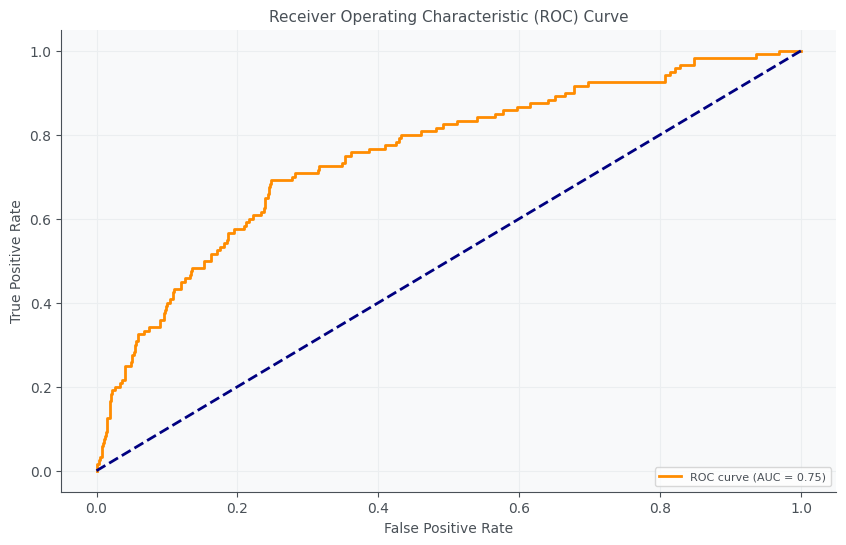

In [97]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, val_anomaly_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The whole dataset contains 7 seizures


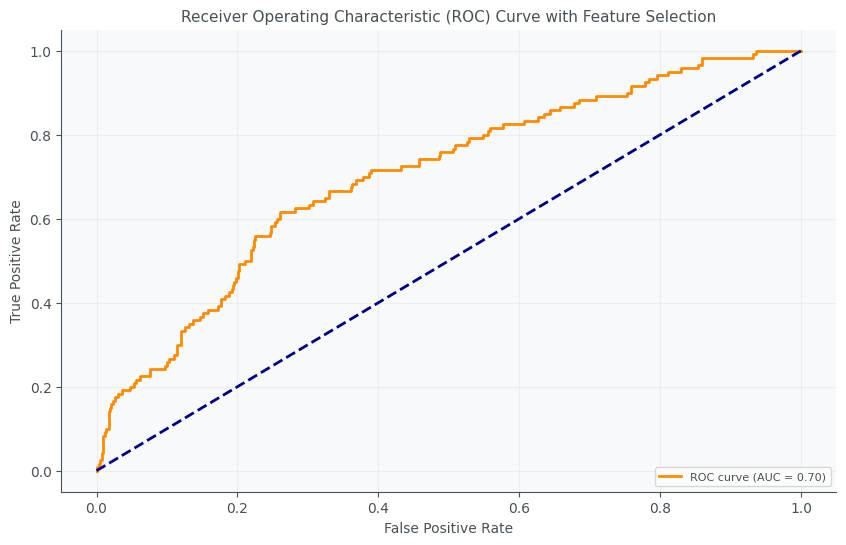

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Generate some example data (replace this with your actual data)
# X should be your feature matrix, y should be your labels (1 for normal, -1 for anomaly)


# Split the data into training and testing sets
annotated_dataset['dayhour'] = annotated_dataset.index.hour

X_train, X_test, y_train, y_test = dataset_preparation(annotated_dataset, train_sz=TRAIN_SZ, columns_to_drop=columns_to_drop, scaler=StandardScaler(), remove_from_train=True)
y_train = (y_train == 'preictal').astype(int)
y_test = (y_test == 'preictal').astype(int)

# Feature selection using SelectKBest with ANOVA F-statistic
k_best = SelectKBest(f_classif, k=10)  # Adjust the number of features based on your needs
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

# Train the model on the selected features
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train_kbest)

# Predict the anomaly scores on the test set
y_scores = model.decision_function(X_test_kbest)

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Feature Selection')
plt.legend(loc='lower right')
plt.show()


In [115]:
print(f'{roc_auc:.3f}')

0.704
